In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import datasets, metrics

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

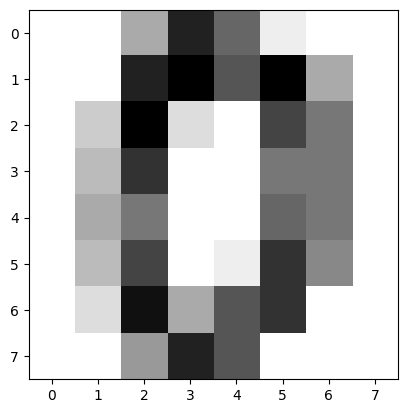

In [4]:
digits = datasets.load_digits()
plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')

# 원핫 엔코딩

In [5]:
Y = pd.get_dummies(digits.target).values

In [6]:
Y

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False,  True, False]])

In [7]:
X = digits.data

# 데이터 분할

In [32]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(X,Y,test_size=0.2) 

# shape를 통해 제대로 분리 됐는지 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1437, 64) (360, 64) (1437, 10) (360, 10)


In [33]:
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

In [34]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [35]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1437, 64]),
 torch.Size([360, 64]),
 torch.Size([1437]),
 torch.Size([360]))

# 모델 정의

In [37]:
class DiabatesDense(nn.Module):
    def __init__(self):
        super(DiabatesDense, self).__init__()
        self.fc1 = nn.Linear(64, 48)
        self.fc2 = nn.Linear(48, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 10)  #피쳐가 10개임 0~9
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model, loss function, and optimizer
model = DiabatesDense()

# 손실 함수 및 최적화 기법 정의

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습

In [41]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        labels = labels.long()
        #labels = labels.float().unsqueeze(1)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            #labels = labels.float().unsqueeze(1)   
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  #이진 분류에서는 사용 X. 다중에서 사용

            #probs = torch.sigmoid(outputs)          #이진에서
            #predicted = (probs >= 0.5).float()      #사용

            total += labels.size(0)
            correct += (predicted == labels).sum().item()  
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 2.0095, Accuracy: 51.67%
Epoch 2/20, Loss: 1.0383, Accuracy: 88.33%
Epoch 3/20, Loss: 0.3936, Accuracy: 92.22%
Epoch 4/20, Loss: 0.2392, Accuracy: 93.61%
Epoch 5/20, Loss: 0.1722, Accuracy: 93.06%
Epoch 6/20, Loss: 0.1505, Accuracy: 92.78%
Epoch 7/20, Loss: 0.1206, Accuracy: 96.39%
Epoch 8/20, Loss: 0.1263, Accuracy: 95.56%
Epoch 9/20, Loss: 0.0958, Accuracy: 96.11%
Epoch 10/20, Loss: 0.0862, Accuracy: 97.50%
Epoch 11/20, Loss: 0.0748, Accuracy: 96.39%
Epoch 12/20, Loss: 0.0707, Accuracy: 96.67%
Epoch 13/20, Loss: 0.0589, Accuracy: 96.94%
Epoch 14/20, Loss: 0.0578, Accuracy: 95.83%
Epoch 15/20, Loss: 0.0548, Accuracy: 97.22%
Epoch 16/20, Loss: 0.0459, Accuracy: 97.50%
Epoch 17/20, Loss: 0.0397, Accuracy: 96.94%
Epoch 18/20, Loss: 0.0351, Accuracy: 97.50%
Epoch 19/20, Loss: 0.0327, Accuracy: 96.67%
Epoch 20/20, Loss: 0.0264, Accuracy: 97.22%
Training complete.


# 모델 평가

In [42]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        #probs = torch.sigmoid(outputs)     #이진에서
        #predicted = (probs >= 0.5).float() #사용
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[31  0  0  0  1  0  0  0  0  0]
 [ 0 39  0  0  0  0  0  0  0  1]
 [ 0  0 34  0  0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 33  0  0  2  0  0]
 [ 0  1  0  0  0 41  0  0  0  0]
 [ 0  0  0  0  0  0 35  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  2  0  0  0  0  0  0 35  0]
 [ 0  0  0  1  0  0  0  1  1 36]]
F1 Score: 0.97
Precision: 0.97
Recall: 0.97
Specificity: 1.00
